In [157]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SimpleRNN
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

# Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


# Utility
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# New Section

In [158]:
df = pd.read_csv("Twitter_Data.csv")
df1 = df

In [159]:
df.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [160]:
df = df[df.category != 0.0]

In [161]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107765 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [162]:
DATASET_COLUMNS = ["clean_text", "category"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

SEQUENCE_LENGTH = 300
EPOCHS = 50
BATCH_SIZE = 1024

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250


In [163]:
df.isnull().sum()

clean_text    2
category      7
dtype: int64

In [164]:
df.dropna(how='any', inplace=True)
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [165]:
decode_map = {-1.0: "NEGATIVE", 1.0: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [166]:
%%time
df.category = df.category.apply(lambda x: decode_sentiment(x))

CPU times: user 31.7 ms, sys: 3.98 ms, total: 35.6 ms
Wall time: 35.3 ms


In [167]:
stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)

stemmer = SnowballStemmer("english")

In [168]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions

df['mod_text'] = df['clean_text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))

In [169]:
df['tokenized'] = df['mod_text'].apply(word_tokenize)

In [170]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

In [171]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

In [172]:
# Applying part of speech tags.

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

In [173]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [174]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['Final'] = [' '.join(map(str, l)) for l in df['lemmatized']]

In [175]:
print("Total Rows =", len(df.clean_text))

Total Rows = 107758


In [176]:
df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,Final
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [177]:
df_mod = df[["Final", "category"]]
df_mod.head()

,Final,category
0,modi promise minimum government maximum govern...,NEGATIVE
2,say vote modi welcome bjp tell rahul main camp...,POSITIVE
3,ask supporter prefix chowkidar name modi great...,POSITIVE
4,answer among powerful world leader today trump...,POSITIVE
8,upcoming election india saga go important pair...,POSITIVE


In [178]:
df_train, df_test = train_test_split(df_mod, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 86206
TEST size: 21552


In [179]:
%%time
documents = [text.split() for text in df_train.Final]

CPU times: user 145 ms, sys: 46.2 ms, total: 191 ms
Wall time: 193 ms


In [180]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [181]:
w2v_model.build_vocab(documents)

In [182]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 8353


In [183]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 2min 23s, sys: 539 ms, total: 2min 24s
Wall time: 1min 26s


(37099518, 45364480)

In [184]:
w2v_model.wv.most_similar("mom")

[('dad', 0.46934497356414795),
 ('mother', 0.46515747904777527),
 ('italy', 0.4437188506126404),
 ('daughter', 0.42541003227233887),
 ('sambit', 0.3910185992717743),
 ('beta', 0.3800462782382965),
 ('patra', 0.3720467686653137),
 ('son', 0.37152332067489624),
 ('parent', 0.365308552980423),
 ('nephew', 0.36126795411109924)]

In [185]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Final)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 70297
CPU times: user 1.64 s, sys: 80.6 ms, total: 1.72 s
Wall time: 1.65 s


In [186]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Final), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Final), maxlen=SEQUENCE_LENGTH)

CPU times: user 1.7 s, sys: 34.1 ms, total: 1.73 s
Wall time: 1.74 s


In [187]:
labels = df_train.category.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [188]:
encoder = LabelEncoder()
encoder.fit(df_train.category.tolist())

y_train = encoder.transform(df_train.category.tolist())
y_test = encoder.transform(df_test.category.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (86206, 1)
y_test (21552, 1)


In [189]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (86206, 300)
y_train (86206, 1)

x_test (21552, 300)
y_test (21552, 1)


In [190]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

In [191]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(70297, 300)


In [192]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [193]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(Conv1D(filters=48, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          21089100  
                                                                 
 dropout_3 (Dropout)         (None, 300, 300)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 298, 48)           43248     
                                                                 
 conv1d_4 (Conv1D)           (None, 296, 16)           2320      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 148, 16)           0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 50)                13400     
                                                      

In [194]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [195]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [196]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6622

76/76 [==============================] - 58s 703ms/step - loss: 0.6092 - accuracy: 0.6622 - val_loss: 0.5275 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.7094

76/76 [==============================] - 52s 688ms/step - loss: 0.5282 - accuracy: 0.7094 - val_loss: 0.4616 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7660

76/76 [==============================] - 52s 691ms/step - loss: 0.4861 - accuracy: 0.7660 - val_loss: 0.4295 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.7897

76/76 [==============================] - 51s 678ms/step - loss: 0.4487 - accuracy: 0.7897 - val_loss: 0.3654 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 5/50
76/76 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8074

76/76 [==============================] - 52s 673ms/step - loss: 0.4071 - accuracy: 0.8074 - val_loss: 0.3454 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 6/50
76/76 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8162

76/76 [==============================] - 52s 682ms/step - loss: 0.3873 - accuracy: 0.8162 - val_loss: 0.3305 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 7/50
76/76 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8278

76/76 [==============================] - 52s 683ms/step - loss: 0.3721 - accuracy: 0.8278 - val_loss: 0.3210 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 8/50
76/76 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8344

76/76 [==============================] - 51s 676ms/step - loss: 0.3605 - accuracy: 0.8344 - val_loss: 0.3133 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 9/50
76/76 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8388

76/76 [==============================] - 51s 666ms/step - loss: 0.3532 - accuracy: 0.8388 - val_loss: 0.3085 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 10/50
76/76 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8419

76/76 [==============================] - 52s 686ms/step - loss: 0.3463 - accuracy: 0.8419 - val_loss: 0.3099 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 11/50
76/76 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8445

76/76 [==============================] - 51s 676ms/step - loss: 0.3399 - accuracy: 0.8445 - val_loss: 0.3011 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 12/50
76/76 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.8490

76/76 [==============================] - 51s 668ms/step - loss: 0.3336 - accuracy: 0.8490 - val_loss: 0.2960 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 13/50
76/76 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8522

76/76 [==============================] - 52s 669ms/step - loss: 0.3270 - accuracy: 0.8522 - val_loss: 0.2957 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 14/50
76/76 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8553

76/76 [==============================] - 51s 678ms/step - loss: 0.3234 - accuracy: 0.8553 - val_loss: 0.2919 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 15/50
76/76 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8585

76/76 [==============================] - 52s 691ms/step - loss: 0.3174 - accuracy: 0.8585 - val_loss: 0.2906 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 16/50
76/76 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8595

76/76 [==============================] - 50s 655ms/step - loss: 0.3135 - accuracy: 0.8595 - val_loss: 0.2877 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 17/50
76/76 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8611

76/76 [==============================] - 52s 688ms/step - loss: 0.3105 - accuracy: 0.8611 - val_loss: 0.2845 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 18/50
76/76 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8631

76/76 [==============================] - 52s 680ms/step - loss: 0.3073 - accuracy: 0.8631 - val_loss: 0.2821 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 19/50
76/76 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8652

76/76 [==============================] - 51s 679ms/step - loss: 0.3048 - accuracy: 0.8652 - val_loss: 0.2813 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 20/50
76/76 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8662

76/76 [==============================] - 49s 650ms/step - loss: 0.3008 - accuracy: 0.8662 - val_loss: 0.2815 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 21/50
76/76 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8676

76/76 [==============================] - 51s 674ms/step - loss: 0.2986 - accuracy: 0.8676 - val_loss: 0.2782 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 22/50
76/76 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8694

76/76 [==============================] - 52s 680ms/step - loss: 0.2944 - accuracy: 0.8694 - val_loss: 0.2755 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 23/50
76/76 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8706

76/76 [==============================] - 51s 670ms/step - loss: 0.2926 - accuracy: 0.8706 - val_loss: 0.2783 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 24/50
76/76 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8706

76/76 [==============================] - 52s 670ms/step - loss: 0.2933 - accuracy: 0.8706 - val_loss: 0.2755 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 25/50
76/76 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8722

76/76 [==============================] - 52s 683ms/step - loss: 0.2908 - accuracy: 0.8722 - val_loss: 0.2761 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 26/50
76/76 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.8741

76/76 [==============================] - 52s 688ms/step - loss: 0.2845 - accuracy: 0.8741 - val_loss: 0.2766 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 27/50
76/76 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8742

76/76 [==============================] - 50s 657ms/step - loss: 0.2855 - accuracy: 0.8742 - val_loss: 0.2756 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 28/50
76/76 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8785

76/76 [==============================] - 52s 683ms/step - loss: 0.2776 - accuracy: 0.8785 - val_loss: 0.2733 - val_accuracy: 0.8864 - lr: 1.0000e-04
Epoch 29/50
76/76 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.8797

76/76 [==============================] - 53s 701ms/step - loss: 0.2765 - accuracy: 0.8797 - val_loss: 0.2734 - val_accuracy: 0.8873 - lr: 1.0000e-04
Epoch 30/50
76/76 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8777

76/76 [==============================] - 52s 688ms/step - loss: 0.2777 - accuracy: 0.8777 - val_loss: 0.2730 - val_accuracy: 0.8875 - lr: 1.0000e-04
Epoch 31/50
76/76 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8802

76/76 [==============================] - 52s 693ms/step - loss: 0.2754 - accuracy: 0.8802 - val_loss: 0.2733 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 32/50
76/76 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8812

76/76 [==============================] - 51s 668ms/step - loss: 0.2724 - accuracy: 0.8812 - val_loss: 0.2721 - val_accuracy: 0.8886 - lr: 1.0000e-04
Epoch 33/50
76/76 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8795

76/76 [==============================] - 53s 693ms/step - loss: 0.2755 - accuracy: 0.8795 - val_loss: 0.2714 - val_accuracy: 0.8877 - lr: 1.0000e-04
Epoch 34/50
76/76 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.8791

76/76 [==============================] - 51s 679ms/step - loss: 0.2743 - accuracy: 0.8791 - val_loss: 0.2717 - val_accuracy: 0.8867 - lr: 1.0000e-04
Epoch 35/50
76/76 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.8803

76/76 [==============================] - 52s 684ms/step - loss: 0.2746 - accuracy: 0.8803 - val_loss: 0.2716 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 36/50
76/76 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.8819

76/76 [==============================] - 51s 672ms/step - loss: 0.2709 - accuracy: 0.8819 - val_loss: 0.2721 - val_accuracy: 0.8873 - lr: 1.0000e-04
Epoch 37/50
76/76 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8823

76/76 [==============================] - 51s 667ms/step - loss: 0.2714 - accuracy: 0.8823 - val_loss: 0.2718 - val_accuracy: 0.8869 - lr: 1.0000e-04
Epoch 38/50
76/76 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8818

76/76 [==============================] - 52s 683ms/step - loss: 0.2704 - accuracy: 0.8818 - val_loss: 0.2706 - val_accuracy: 0.8873 - lr: 1.0000e-04
Epoch 39/50
76/76 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8818

76/76 [==============================] - 51s 679ms/step - loss: 0.2720 - accuracy: 0.8818 - val_loss: 0.2710 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 40/50
76/76 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8829

76/76 [==============================] - 50s 657ms/step - loss: 0.2701 - accuracy: 0.8829 - val_loss: 0.2719 - val_accuracy: 0.8874 - lr: 1.0000e-04
Epoch 41/50
76/76 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.8827

76/76 [==============================] - 52s 689ms/step - loss: 0.2709 - accuracy: 0.8827 - val_loss: 0.2720 - val_accuracy: 0.8874 - lr: 1.0000e-04
Epoch 42/50
76/76 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8815

76/76 [==============================] - 52s 686ms/step - loss: 0.2704 - accuracy: 0.8815 - val_loss: 0.2714 - val_accuracy: 0.8888 - lr: 1.0000e-04
Epoch 43/50
76/76 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8822

76/76 [==============================] - 52s 682ms/step - loss: 0.2685 - accuracy: 0.8822 - val_loss: 0.2709 - val_accuracy: 0.8885 - lr: 1.0000e-04
Epoch 44/50
76/76 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8833

76/76 [==============================] - 50s 653ms/step - loss: 0.2684 - accuracy: 0.8833 - val_loss: 0.2709 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 45/50
76/76 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.8825

76/76 [==============================] - 52s 683ms/step - loss: 0.2693 - accuracy: 0.8825 - val_loss: 0.2708 - val_accuracy: 0.8879 - lr: 1.0000e-05
Epoch 46/50
76/76 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8804

76/76 [==============================] - 52s 685ms/step - loss: 0.2716 - accuracy: 0.8804 - val_loss: 0.2707 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 47/50
76/76 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8823

76/76 [==============================] - 51s 677ms/step - loss: 0.2676 - accuracy: 0.8823 - val_loss: 0.2707 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 48/50
76/76 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8839

76/76 [==============================] - 51s 662ms/step - loss: 0.2694 - accuracy: 0.8839 - val_loss: 0.2706 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 49/50
76/76 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8824

76/76 [==============================] - 54s 709ms/step - loss: 0.2675 - accuracy: 0.8824 - val_loss: 0.2706 - val_accuracy: 0.8879 - lr: 1.0000e-06
Epoch 50/50
76/76 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8834

76/76 [==============================] - 52s 687ms/step - loss: 0.2685 - accuracy: 0.8834 - val_loss: 0.2706 - val_accuracy: 0.8881 - lr: 1.0000e-06
CPU times: user 55min 27s, sys: 5min 33s, total: 1h 1min 1s
Wall time: 43min 4s


In [197]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

22/22 [==============================] - 1s 46ms/step - loss: 0.2676 - accuracy: 0.8890

ACCURACY: 0.8890126347541809
LOSS: 0.26759713888168335
CPU times: user 1.02 s, sys: 92.3 ms, total: 1.11 s
Wall time: 1.34 s


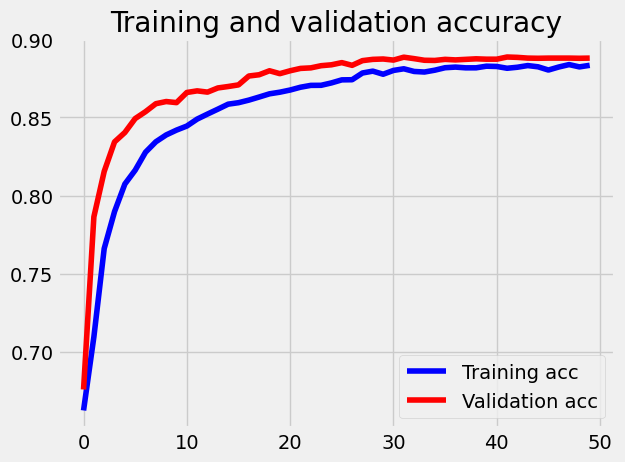

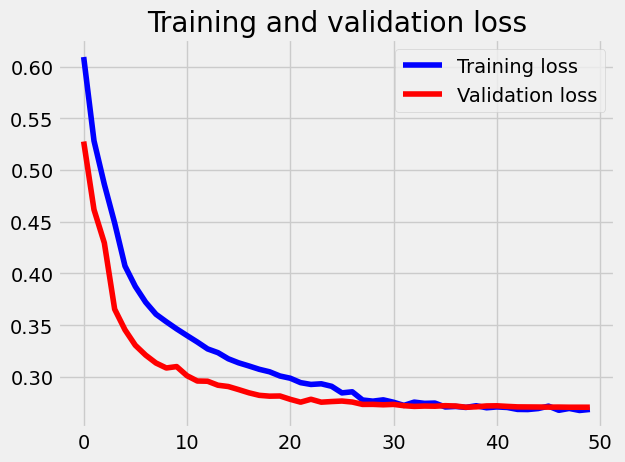

In [198]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [199]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [200]:
def predict(clean_text, include_neutral=True):
    start_at = time.time()
    # Tokenize clean_text
    x_test = pad_sequences(tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [201]:
predict("I love the music")

1/1 [==============================] - 0s 288ms/step


{'label': 'POSITIVE',
 'score': 0.9995843768119812,
 'elapsed_time': 0.4043595790863037}

In [202]:
predict("I have nothing to lose")

1/1 [==============================] - 0s 49ms/step


{'label': 'NEGATIVE',
 'score': 0.34366267919540405,
 'elapsed_time': 0.0957491397857666}

In [203]:
predict("Experience has been bad")

1/1 [==============================] - 0s 53ms/step


{'label': 'NEGATIVE',
 'score': 0.015789005905389786,
 'elapsed_time': 0.0920248031616211}

In [204]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.category)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3/3 [==============================] - 1s 260ms/step
CPU times: user 1.19 s, sys: 132 ms, total: 1.32 s
Wall time: 1.32 s


In [205]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

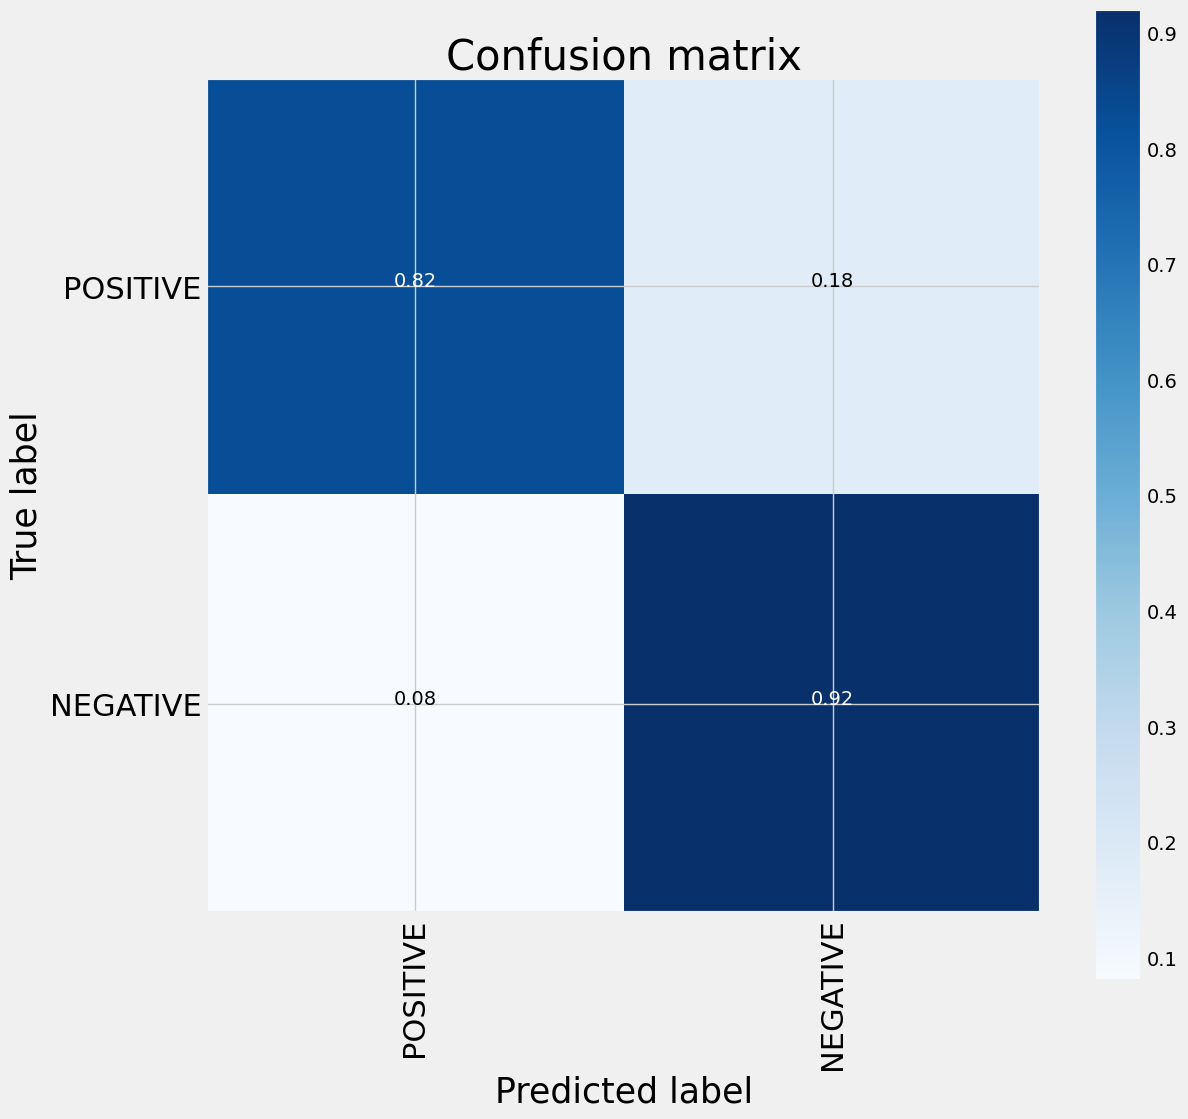

CPU times: user 454 ms, sys: 245 ms, total: 699 ms
Wall time: 431 ms


In [206]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.category.unique(), title="Confusion matrix")
plt.show()

In [207]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.83      0.82      0.83      7026
    POSITIVE       0.92      0.92      0.92     14526

    accuracy                           0.89     21552
   macro avg       0.87      0.87      0.87     21552
weighted avg       0.89      0.89      0.89     21552



In [208]:
accuracy_score(y_test_1d, y_pred_1d)

0.8890126206384559